In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl

import flamedisx as fd

import os
import glob

import collections

import sys
sys.path.append('../../../xlzd_reqtask_nufog')
from fogtask.fogtask import *

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(


In [2]:
def hist_to_cdf(hist, ordering):
    return np.cumsum(hist.histogram.ravel()[ordering]) / hist.n

In [3]:
def ROC_2D(template_sig, template_bg):
    ratio = (template_bg + 1e-10) / (template_sig + 1e-10)
    ratio_ordering = np.argsort(ratio.histogram.ravel())

    roc = (hist_to_cdf(template_bg, ratio_ordering),
           hist_to_cdf(template_sig, ratio_ordering))

    return roc

In [4]:
def get_nominal_parameters(version='vFIELD_SCAN'):
    all_parameters = get_parameters(version=version, mode='LENR')
    analysis_parameters = all_parameters['wimp_analysis_parameters']
    
    ret_fix, ret_iter, nominal_parameters, template_format_string = get_template_parameters(version=version, mode='LENR')
    parameters = deepcopy(nominal_parameters)
    
    fixed_parameters = dict(
        cS1_min = analysis_parameters['cs1_range']['value'][0],
        cS1_max = analysis_parameters['cs1_range']['value'][-1],
        log10_cS2_min = analysis_parameters['cs2_range']['value'][0],
        log10_cS2_max = analysis_parameters['cs2_range']['value'][-1],
        s2_thr = analysis_parameters['s2_threshold']['value'],
        coin_level = analysis_parameters['coincidence_threshold']['value'],
        g1_gas = parameters['g1_gas'],
        temperature_K = parameters['temperature'],
        pressure_bar = parameters['pressure'],
        num_pmts = parameters['n_pmts'],
        double_pe_fraction = parameters['p_dpe'],
        s2Fano = parameters['s2_fano'],
        spe_res = parameters['spe_resolution'],
        spe_thr = parameters['spe_threshold'],
        spe_eff = parameters['spe_efficiency'],
        configuration = parameters['lce_configuration'],
        drift_field_V_cm = parameters['drift_field'],
        gas_field_kV_cm = parameters['gas_field'],
        g1 = parameters['PMT_quantum_efficiency'],
        elife_ns = parameters['electron_livetime'] * 1e6)
    
    return fixed_parameters

In [5]:
def get_roc_metric_1d(param_name, param_value, sim_stats=int(1e6)):
    
    parameters = get_nominal_parameters()
    parameters[param_name] = param_value
    
    er = fd.xlzd.XLZDERSource(**parameters, energy_min=0.01, energy_max=10.)
    nr = fd.xlzd.XLZDNRSource(**parameters, energy_min=0.01, energy_max=60.)
    
    er_hist = Histdd(bins=100, range=[[parameters['cS1_min'], parameters['cS1_max']],
                                      [parameters['log10_cS2_min'], parameters['log10_cS2_max']]], axis_names=['cS1', 'log10_cS2'])
    er_data = er.simulate(sim_stats)
    er_hist.add(er_data['cs1'], np.log10(er_data['cs2']))
    er_hist.histogram = er_hist.histogram / er_hist.n

    nr_hist = Histdd(bins=100, range=[[parameters['cS1_min'], parameters['cS1_max']],
                                      [parameters['log10_cS2_min'], parameters['log10_cS2_max']]], axis_names=['cS1', 'log10_cS2'])
    nr_data = nr.simulate(sim_stats)
    nr_hist.add(nr_data['cs1'], np.log10(nr_data['cs2']))
    nr_hist.histogram = nr_hist.histogram / nr_hist.n
    
    roc = ROC_2D(nr_hist, er_hist)
    bg_at_50_sig = np.interp(0.5, xp=roc[1], fp=roc[0]) * 100. # return as %
    
    return bg_at_50_sig

In [6]:
import warnings
warnings.filterwarnings('ignore')

drift_fields_V_cm = [10., 15., 20., 50., 100., 200., 300., 400.]
roc_metrics_drift_field = []

for drift_field_V_cm in drift_fields_V_cm:
    print(drift_field_V_cm)
    bg_at_50_sig = get_roc_metric_1d('drift_field_V_cm', drift_field_V_cm)
    roc_metrics_drift_field.append(bg_at_50_sig)

10.0
15.0
20.0
50.0
100.0
200.0
300.0
400.0


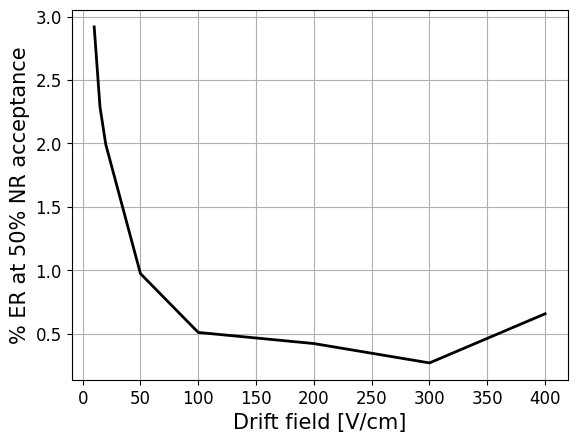

In [7]:
plt.plot(drift_fields_V_cm, roc_metrics_drift_field, color='k', lw=2)
plt.xlabel('Drift field [V/cm]')
plt.ylabel('% ER at 50% NR acceptance')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
plt.grid()

In [8]:
def get_disco_bands(directory):
    all_exposures = []
    all_bands = []
    
    subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and len(glob.glob(f'{f.path}/*.pkl')) > 0]
    for subfolder in subfolders:
        exposure_str = subfolder.split('/')[-1]
        all_exposures.append(float(exposure_str.split('_')[0]))
    
        disco_sigs = pkl.load(open(f'{subfolder}/disco_sigs_0.pkl', 'rb'))
        intervals = fd.IntervalCalculator(signal_source_names=['WIMP'],
                                          stat_dists=disco_sigs)

        bands, mus = intervals.get_bands_discovery()
        all_bands.append(bands['WIMP'][mus['WIMP'][0]])

    return all_exposures, all_bands

In [9]:
def get_crossing(x, y, crit_val=5.):
    crossing_points = np.argwhere(np.diff(np.sign(y - np.ones_like(y) * crit_val)) > 0.).flatten()
    
    try:
        x_left = x[crossing_points[0]]
        x_right = x[crossing_points[0] + 1]
        y_left = y[crossing_points[0]]
        y_right = y[crossing_points[0] + 1]
    except:
        return x[-1]
    
    gradient = (y_right - y_left) / (x_right - x_left)

    return (crit_val - y_left) / gradient + x_left

In [10]:
files_titles = {'outputs/10_V_cm': '10 V/cm',
                'outputs/15_V_cm': '15 V/cm',
                'outputs/20_V_cm': '20 V/cm',
                'outputs/50_V_cm': '50 V/cm',
                'outputs/100_V_cm': '100 V/cm',
                'outputs/200_V_cm': '200 V/cm',
                'outputs/300_V_cm': '300 V/cm',}

In [11]:
def produce_plot(file, title):
    expsoures, bands = get_disco_bands(directory=file)
    
    plt.figure()
    delta = 5

    medians = dict()
    for exposure, band in zip(expsoures, bands):

        plt.plot([exposure-delta, exposure+delta],
                 2*[band[0]],
                 color='k', linewidth=2)
        plt.fill_between([exposure-delta, exposure+delta],
                         2*[band[-1]], 2*[band[1]],
                         facecolor='#00ff00', alpha=0.5)
        plt.fill_between([exposure-delta, exposure+delta],
                         2*[band[-2]], 2*[band[2]],
                         facecolor='#ffff00', alpha=0.5)

        medians[exposure] = band[0]

    medians = collections.OrderedDict(sorted(medians.items()))
    exposures = list(medians.keys())
    meds = list(medians.values())
    crossing = get_crossing(exposures, meds)
    
    plt.hlines(5., np.min(exposures), np.max(exposures), color='darkred', linestyle='--', linewidth=1)
    plt.text(np.min(exposures), 5.2, 'Discovery', color='darkred')

    plt.xlabel("Exposure [ty]")
    plt.ylabel("Discovery potential [$\sigma$]")
    plt.title(f"{title}: {crossing:.2f} ty")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax = plt.gca()
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)

    plt.ylim (0., 10.)

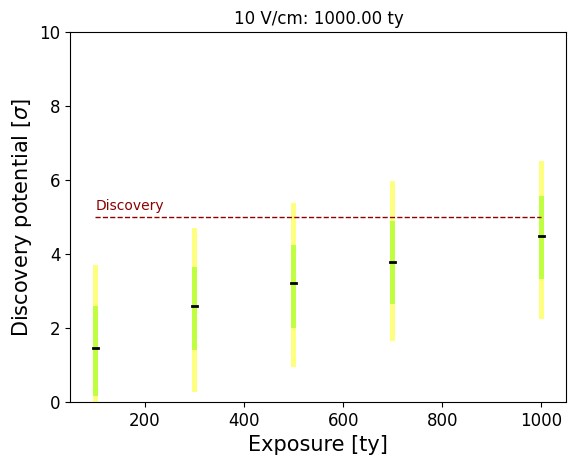

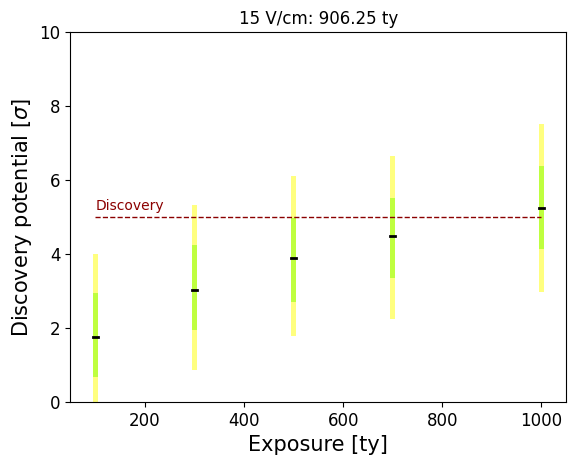

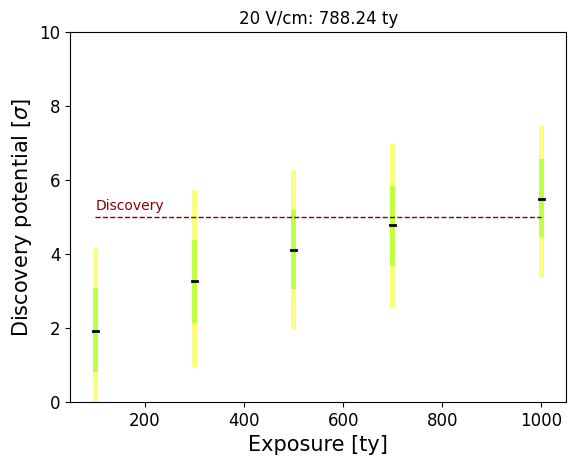

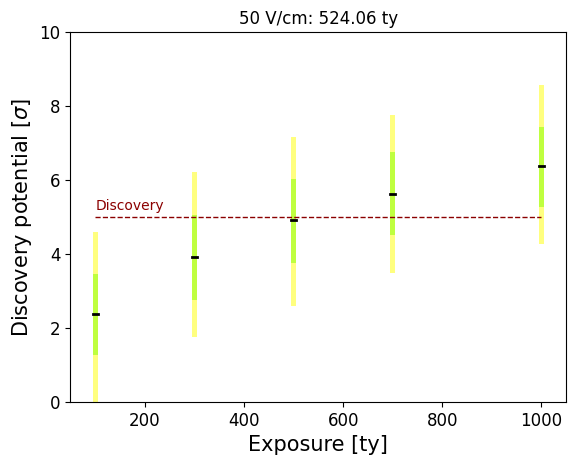

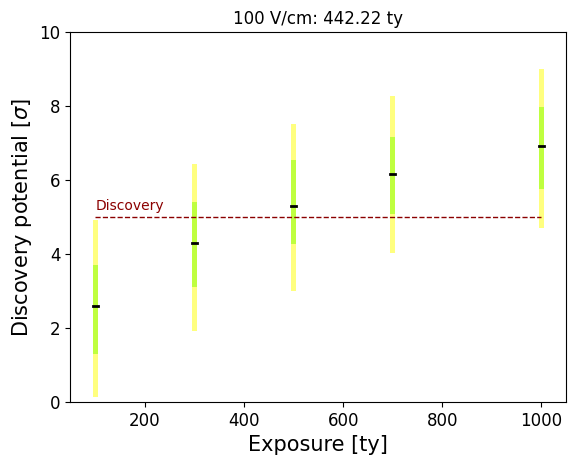

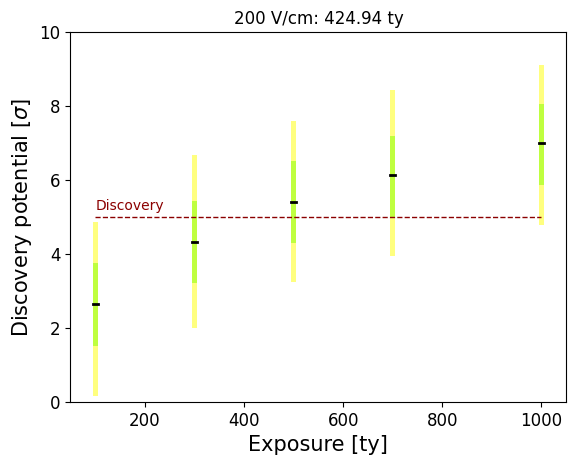

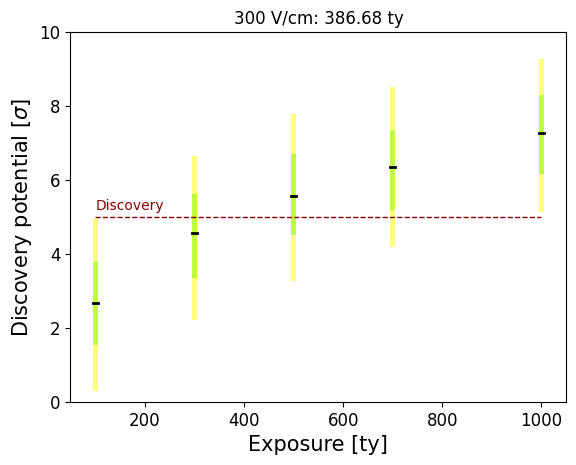

In [12]:
for file, title in files_titles.items():
    produce_plot(file, title)

In [13]:
def get_fields_vs_exposure(files_titles):
    fields_vs_exposure = dict()
    
    for file, title in files_titles.items():
        expsoures, bands = get_disco_bands(directory=file)
        
        medians = dict()
        for exposure, band in zip(expsoures, bands):
            medians[exposure] = band[0]

        medians = collections.OrderedDict(sorted(medians.items()))
        exposures = list(medians.keys())
        meds = list(medians.values())
        crossing = get_crossing(exposures, meds)
        
        field = float(title.split(' ')[0])
        fields_vs_exposure[field] = crossing
    
    return fields_vs_exposure

In [14]:
fields_vs_exposure = get_fields_vs_exposure(files_titles)

In [15]:
print(roc_metrics_drift_field)

[2.919005285974441, 2.2893766068062362, 1.9930462202238577, 0.9742714401440117, 0.5104246366355008, 0.4227121847681032, 0.27008601195057524, 0.6574178612547311]


In [16]:
def field_to_discrimination(field_V_cm):
    return np.interp(field_V_cm, drift_fields_V_cm, roc_metrics_drift_field)

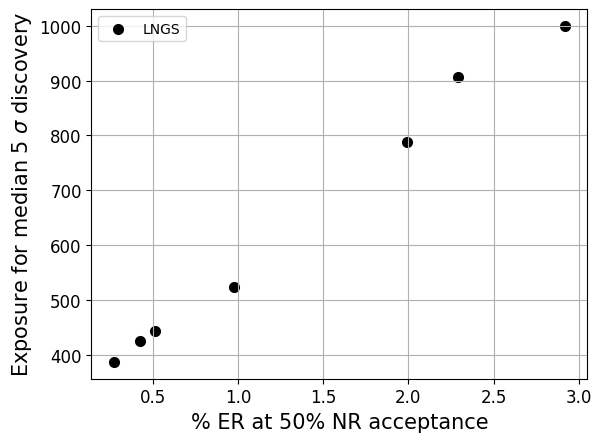

In [17]:
field_values_scan = list(fields_vs_exposure.keys())
discrimination_values_scan = field_to_discrimination(field_values_scan)

plt.scatter(discrimination_values_scan, list(fields_vs_exposure.values()), color='k', lw=2, label='LNGS')

plt.xlabel('% ER at 50% NR acceptance')
plt.ylabel(r'Exposure for median 5 $\sigma$ discovery')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
plt.grid()
plt.legend()